<a href="https://colab.research.google.com/github/Adyypower/LLMs-Model/blob/main/Model_Draffter_with__web_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q -U langchain langchain-google-genai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.7.0 which is incompatible.


In [3]:
!pip install -q langgraph ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.2 MB/s eta 0:00:00


In [4]:
from google.colab import userdata
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from ddgs import DDGS

In [5]:
import os
try:
    os.environ["GOOGLE_API_KEY"]= userdata.get("GOOGLE_API_KEY")
except userdata.SecretNotFoundError:
  print("ERROR: GOOGLE_API_KEY not found in Colab secrets.")
  print("Please go to 'Secrets' (the key icon in the left panel) and add your Google AI ")

In [6]:
document_content = ""

In [7]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage],add_messages]

In [8]:
@tool
def update(content: str) -> str:
    """Updates the document with the provided content."""
    global document_content
    document_content = content
    return f"Document has been updated successfully! The current content is:\n{document_content}"


In [10]:
@tool
def search_web(query: str) -> str:
    """Searches the web for a given query to find up-to-date information."""
    print(f"\n🔎 Searching the web for: '{query}'...")
    try:
        with DDGS() as ddgs:
            results = [r for r in ddgs.text(query, max_results=4)]
        print("✅ Search complete.")
        return str(results) if results else "No results found."
    except Exception as e:
        return f"Error during web search: {e}"

In [11]:
@tool
def save(filename: str) -> str:
    """Save the current document to a text file and finish the process.

    Args:
        filename: Name for the text file.
    """

    global document_content

    if not filename.endswith('.txt'):
        filename = f"{filename}.txt"


    try:
        with open(filename, 'w') as file:
            file.write(document_content)
        print(f"\n💾 Document has been saved to: {filename}")
        return f"Document has been saved successfully to '{filename}'."

    except Exception as e:
        return f"Error saving document: {str(e)}"


tools = [update, save,search_web]

In [12]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash").bind_tools(tools)

In [13]:
def our_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are a helpful and autonomous AI Research Assistant.
    Your mission is to create a comprehensive report based on the user's request. Follow this logical workflow:
    1.  **GATHER INFO**: Use the `search_web` tool if you need information.
    2.  **SYNTHESIZE & WRITE DRAFT**: After gathering info, you MUST write a comprehensive draft using the `update` tool. Do not ask for permission; this is your primary job.
    3.  **PRESENT & GET FEEDBACK**: After updating the draft, your response MUST be to present the draft to the user and ask for feedback.
    4.  **SAVE**: Only use the `save` tool when the user explicitly asks to save the final document.

    The current draft of the document is:
    ---
    {document_content}
    ---
    """)
    if not state["messages"]:
        user_input = "I'm ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)

    else:
        user_input = input("\nWhat would you like to do with the document? ")
        print(f"\n👤 USER: {user_input}")
        user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]

    response = model.invoke(all_messages)

    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": list(state["messages"]) + [user_message, response]}



In [14]:
def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["messages"]

    if not messages:
        return "continue"

    # This looks for the most recent tool message....
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if (isinstance(message, ToolMessage) and
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end" # goes to the end edge which leads to the endpoint

    return "continue"

In [15]:
def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return

    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")

In [17]:
graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("agent")

graph.add_edge("agent", "tools")


In [18]:
graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)

In [19]:
app = graph.compile()

In [24]:

def run_document_agent():
    print("\n ===== DRAFTER ===telek")

    # Start with an initial message
    initial_message = HumanMessage(content="Hello, I'm ready to start drafting.")
    state = {"messages": [initial_message]}

    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])

    print("\n ===== DRAFTER FINISHED ===telek")

if __name__ == "__main__":
    run_document_agent()


 ===== DRAFTER ===telek

What would you like to do with the document? who narender modi write short not on it

👤 USER: who narender modi write short not on it

🤖 AI: 
🔧 USING TOOLS: ['search_web']

🔎 Searching the web for: 'Narendra Modi short note'...
✅ Search complete.

🛠️ TOOL RESULT: [{'title': 'Narendra Modi - Wikipedia', 'href': 'https://en.wikipedia.org/wiki/Narendra_Modi', 'body': 'Narendra Damodardas Modi[a] (born 17 September 1950) is an Indian politician who has served as the prime minister of India since 2014. Modi was the chief minister of Gujarat from 2001 to 2014 and is the member of parliament (MP) for Varanasi. He is a member of the Bharatiya Janata Party (BJP) and of the Rashtriya Swayamsevak Sangh (RSS), a right-wing Hindutva paramilitary volunteer ...'}, {'title': 'Paragraph on Narendra Modi 100, 150, 200, 250 to 300 Words for Kids ...', 'href': 'https://www.aplustopper.com/paragraph-on-narendra-modi/', 'body': 'Paragraph on Narendra Modi - 250 to 300 words for Cla

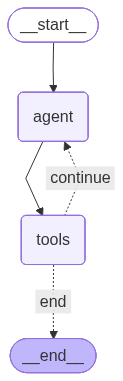

In [23]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))
